In [1]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>
# Challenge S2: Reconocimiento de dígitos

## Objetivo

Nuestro objetivo en este challenge es implementar un mecanismo automático que a partir de una imagen de un cheque sea capaz de reconocer la cantidad manuscrita que hay en el mismo.

<img src="cheque.jpg">

Para ello trabajaremos con un dataset abierto denominado `digits` que contiene dígitos manuscritos etiquetados.

## Configuración del entorno

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import scikitplot as skplt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

## Carga de datos

En esta ocasión vamos a utilizar una dataset denominado 'digits' que contiene imágenes de números manuscritos.

Este dataset está disponible dentro de los datasets de `sklearn` y podemos cargarlo en memoria de la siguiente manera:

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()

In [4]:
print(digits)

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'frame': None, 'feature_names': ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', '

Inspeccionando el dataset podemos ver que es un diccionario. Vamos a navegar un poco en sus propiedades:

In [5]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

En la etiqueta `DESCR` tenemos la descripción del dataset:

In [6]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Podemos ver que en la variable `data` están almacenados los datos.

In [7]:
print(digits.data)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [8]:
print(digits.data.shape)

(1797, 64)


Y viendo su estructura, concluimos que contiene $1797$ instancias, cada una contiene $64$ características.

Además hay un vector:

In [9]:
print(digits.target)

[0 1 2 ... 8 9 8]


In [10]:
print(len(digits.target))

1797


In [11]:
print(digits.target.shape)

(1797,)


Que contiene la clase real de cada instancia.

Tambien disponemos de las imagenes sin "aplanar". Pero para el entrenamiento y las predicciones usamos las imagenes "aplanadas".

In [12]:
print (digits.images.shape)

(1797, 8, 8)


Para estar seguros de que estamos interpretando el dataset podemos dibujarlo de la siguiente manera:

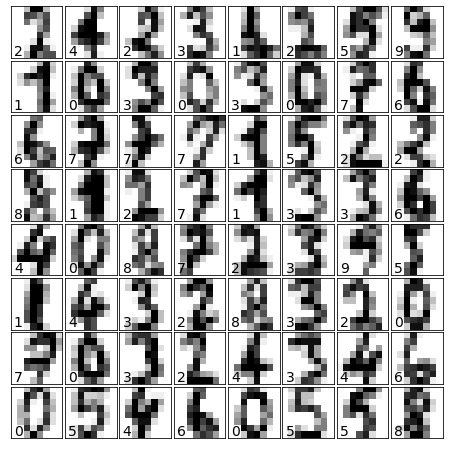

In [13]:
import random

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

random.seed(42)
for i in range(64):
    pos = random.randint(0, len(digits.images) - 1)
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[pos], cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, str(digits.target[pos]))

In [14]:
print("Valor maximo de codificacion de los pixeles: ",np.max(digits.data))
print("Valor minimo de codificacion de los pixeles: ",np.min(digits.data))

Valor maximo de codificacion de los pixeles:  16.0
Valor minimo de codificacion de los pixeles:  0.0


## Conjunto de entrenamiento y test

Divide el conjunto de datos en 2 grupos: entrenamiento y test con una proporción de reparto del 30% (70% entrenamiento, 30% test)

* ¿Cuántos elementos tiene el conjunto de entrenamiento? ¿Y el de test?

In [15]:
# Identificamos lo que van a ser los dataset predictores o X y la variable que se predice o Y
dataset_X = digits.data
dataset_y = digits.target
#Realizamos la partición. El 30% de los elementos se utilizaran en la parte de test.

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

print('El conjunto de entranamiento contiene ',X_train.shape[0], ' elementos')
print('El conjunto de test contiene ',X_test.shape[0], ' elementos')

El conjunto de entranamiento contiene  1257  elementos
El conjunto de test contiene  540  elementos


## Clasificador logístico

Entrena un clasificador logístico para reconocer digitos.

* ¿Qué porcentaje de acierto obtienes?
* ¿Cuales son las clases que más se equivocan entre sí? ¿son lógicos los resultados?

Accuracy: 0.9648148148148148
precision_score: 0.9641864512283596
recall_score: 0.9658412140806343


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

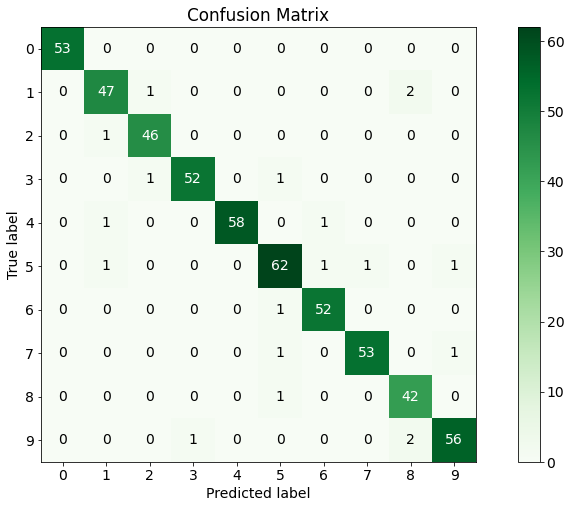

In [16]:
#Instanciamos el clasificador logistico.
logistic = LogisticRegression()

#Entrenamos el algoritmo de clasificación
logistic.fit(X_train, y_train)

#Lo probaos con la parte de test.
y_predicted = logistic.predict(X_test)

print("Accuracy: {}".format(accuracy_score(y_test,y_predicted)))
print("precision_score: {}".format(precision_score(y_test,y_predicted,average='macro')))
print("recall_score: {}".format(recall_score(y_test,y_predicted,average='macro')))

skplt.metrics.plot_confusion_matrix(y_test, y_predicted, labels=np.unique(digits.target),figsize=(15,8),cmap='Greens')

* Obtenemos los siguientes resultados:

    * Accuracy: 0.9648148148148148
    * precision_score: 0.9641864512283596
    * recall_score: 0.9658412140806343
* El número 5, 1, 9 son los que han sido clasificados más veces erroneamente


## Perceptrón multicapa

Entrena un perceptrón multicapa con los datos anteriores (revisa el worksheet si no te acuerdas de como hacerlo).

* ¿Qué porcentaje de acierto obtienes?
* ¿Cuales son las clases que más se equivocan entre sí?
* Compara los resultados del perceptrón y el logístico

Accuracy: 0.9777777777777777
precision_score: 0.9771678264223574
recall_score: 0.9777702624497755


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

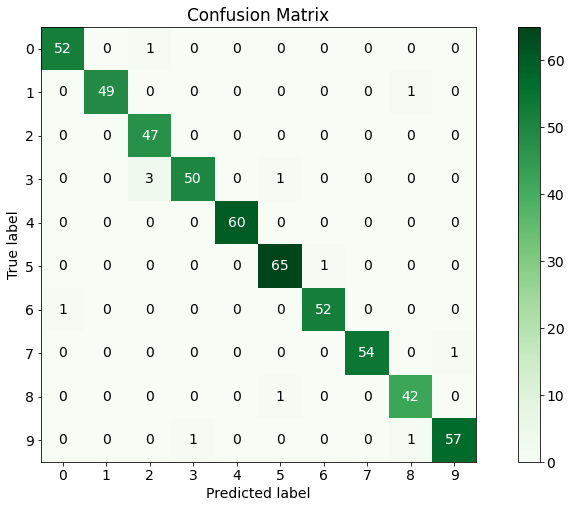

In [17]:
#Instanciamos el Perceptrón Multicapa.
nn = MLPClassifier()

#Entrenamos el algoritmo de clasificación
nn.fit(X_train, y_train)

#Lo probaos con la parte de test.
y_predicted = nn.predict(X_test)

print("Accuracy: {}".format(accuracy_score(y_test,y_predicted)))
print("precision_score: {}".format(precision_score(y_test,y_predicted,average='macro')))
print("recall_score: {}".format(recall_score(y_test,y_predicted,average='macro')))

skplt.metrics.plot_confusion_matrix(y_test, y_predicted, labels=np.unique(digits.target),figsize=(15,8),cmap='Greens')


* Obtenemos los siguientes resultados:

    * Accuracy: 0.9722222222222222
    * precision_score: 0.9719240048715774
    * recall_score: 0.972012626118642
* El número 8 y el 5 son los que han sido clasificados más veces erroneamente
* Comparando los datos observamos que los datos del logítico son:

    * Accuracy: 0.9648148148148148
    * precision_score: 0.9641864512283596
    * recall_score: 0.9658412140806343
    
    * Por lo que la en todos los indicadores el perceptron tiene unos indicadores de acierto mejores que el logistico.

## Análisis de resultados

Analiza con más detalle los resultados del perceptrón. 

* ¿Podrías dibujar los casos en los que se equivoca?.
* Revisando los casos que se equivoca... ¿podrías identificar casos que son outliers? (casos que se equivoca pero es lógico porque no están bien etiquetados en el dataset original)

Tip: Apoyate en la función `dibuja_digito`.

In [18]:
def dibuja_digito(index, data_feature, real_class, predicted_class):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(data_feature.reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    plt.text(10, 5, "Index: " + str(index))
    plt.text(10, 6, "Real: " + str(real_class))
    plt.text(10, 7, "Predicted: " + str(predicted_class))

Los dígitos que no se clasifican bien son  [0 7 3 3 9 8 6 1 5 3 3 9] 

Los indices son :  [124, 133, 149, 156, 159, 239, 244, 270, 339, 431, 488, 516]


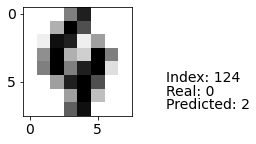

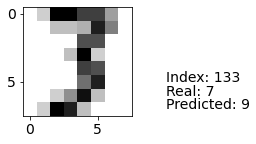

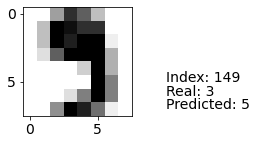

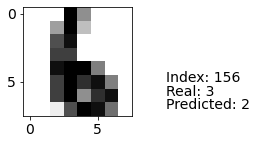

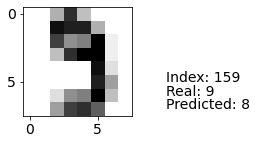

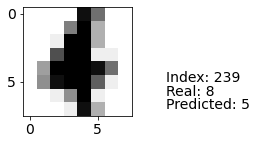

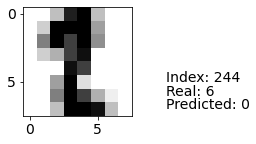

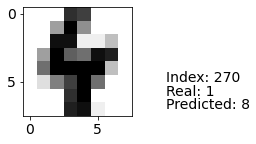

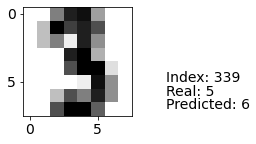

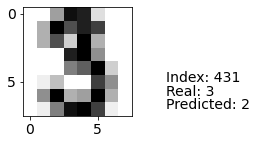

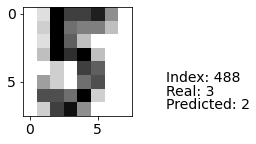

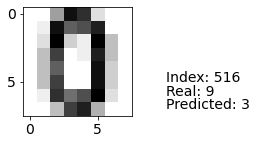

In [19]:
#Vamos a detectar los caos en los que no los clasifca correctamente y los vamos a representar con la función dibuja_digito
index=0
lista_index_ouliers=[]

for index in range(0,(len(y_test)-1)):
    if y_test[index]!=y_predicted[index]:
        lista_index_ouliers.append(index)
        dibuja_digito(index,digits.data[index],y_test[index],y_predicted[index])

print('Los dígitos que no se clasifican bien son ', y_test[y_test!=y_predicted],'\n')        
print('Los indices son : ', lista_index_ouliers)        

## Eliminación de outliers

Elimina los outliers del dataset de test, vuelve a entrenar la red neuronal con un random seed aleatorio y comprueba los resultados con el nuevo dataset de test reducido.

    * Analiza los resultados
    * ¿Es correcto lo que hemos hecho?
    * ¿Que crees que sucedería si eliminasemos tambien los outliers del dataset de entrenamiento?. ¿Mejorarian los resultados?. Solo elabora una respuesta, no es necesario implementar esto en codigo.


Accuracy: 0.9829545454545454
precision_score: 0.9820384073291049
recall_score: 0.9830026164311878


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

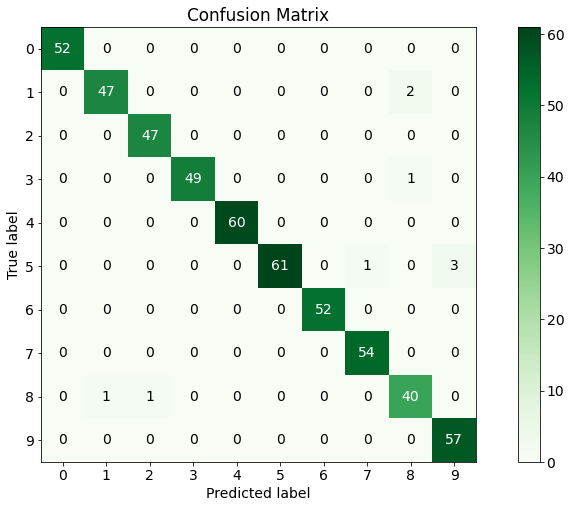

In [20]:
X_test_reducido=np.delete(X_test,lista_index_ouliers,axis=0)
y_test_reducido=np.delete(y_test,lista_index_ouliers)

#Instanciamos el Perceptrón Multicapa.
nn2= MLPClassifier(random_state=42)

#Entrenamos el algoritmo de clasificación
nn2.fit(X_train, y_train)

#Lo probaos con la parte de test.
y_predicted_reducido = nn2.predict(X_test_reducido)

print("Accuracy: {}".format(accuracy_score(y_test_reducido,y_predicted_reducido)))
print("precision_score: {}".format(precision_score(y_test_reducido,y_predicted_reducido,average='macro')))
print("recall_score: {}".format(recall_score(y_test_reducido,y_predicted_reducido,average='macro')))

skplt.metrics.plot_confusion_matrix(y_test_reducido, y_predicted_reducido, labels=np.unique(digits.target),figsize=(15,8),cmap='Greens')





* Entiendo que tal vez hubiera sido mejor que esos "ouliers" se hubieran incorporado a la parte de entrenamiento y así el algoritmo estaría entrenado con más datos.
*  Es posible que se mejoraran los datos pero en concreto para este dataset, pero no de la forma correcta. Estariamos quitando "datos" para el entrenamiento y cuando se enfrentara a datos de "explotación" reales no estaría entrenado totalmente para esa casuística de imagenes. A mi entender creo que se estarían haciendo las cosas al reves, mejoramos reduciendo el dataset en vez de mejorar ampliando los datos del dataset.

## (Extra) Evalúa tus propias imágenes con el modelo entrenado

Genera una imagen de 32x32 píxels y escribe un número en ella. A continuación reconócelo con el mejor modelo que hayas
obtenido en los pasos anteriores.

Recuerda que en la descripción del dataset se especifica como deben ser los números de entrada:

* Imágenes de 8x8 con valores en escala de grises entre 0 y 16
* Número en blanco sobre un fondo negro.

Por último:

* Evalua los resultados obtenidos. ¿cómo podríamos mejorarlos?

In [21]:
from skimage import data, io, filters
from skimage.transform import rescale, resize, downscale_local_mean
img7 = io.imread("tu_digito_7.png")
img8 = io.imread("tu_digito_8.png")
img9 = io.imread("tu_digito_9.png")

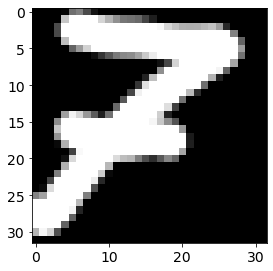

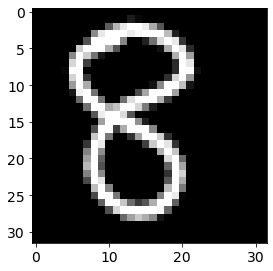

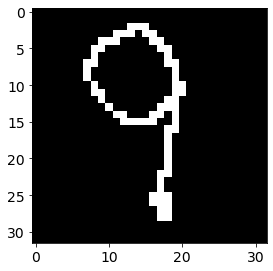

In [22]:
io.imshow(img7)
io.show()
io.imshow(img8)
io.show()
io.imshow(img9)
io.show()

In [23]:
# Función que procesa y prepara la imagen para que pueda ser procesada por los algoritmos.
def procesar_imagen(img):
    
    #Trasformamos en escala de grises
    gray_img = (0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2])
    #Hacemos resize a 8x8
    gray_img = resize(gray_img,(8,8),anti_aliasing=True)
    #Establecemos escala de grises 0-16
    gray_img=(gray_img/16).astype(np.float).round(0)
    #Mostramos imagen procesada
    io.imshow(gray_img, cmap=plt.cm.binary, interpolation='nearest')
    io.show()
    #Aplanamos la imagen
    gray_img_data=np.array([(gray_img.ravel())])
    
    return gray_img_data


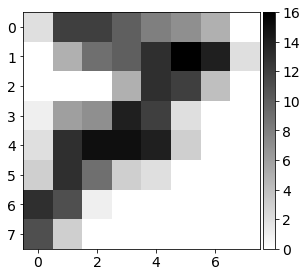

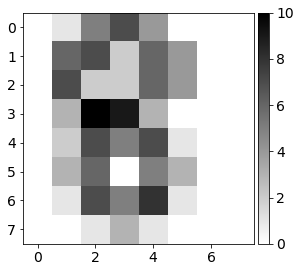

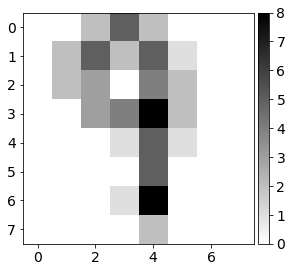

In [24]:
# Procesamos y Aplanamos la imagen
gray_img_data7= procesar_imagen (img7)
gray_img_data8= procesar_imagen (img8)
gray_img_data9= procesar_imagen (img9)

In [25]:
# Regresion Logistica
#Lo probamos con la parte de test.
y_predicted_mio = logistic.predict(gray_img_data7)
print(y_predicted_mio)
y_predicted_mio = logistic.predict(gray_img_data8)
print(y_predicted_mio)
y_predicted_mio = logistic.predict(gray_img_data9)
print(y_predicted_mio)


[7]
[4]
[1]


In [26]:
#Perceptron
#Lo probamos con la parte de test.
y_predicted_mio = nn.predict(gray_img_data7)
print(y_predicted_mio)
y_predicted_mio = nn.predict(gray_img_data8)
print(y_predicted_mio)
y_predicted_mio = nn.predict(gray_img_data9)
print(y_predicted_mio)

[4]
[8]
[5]


In [27]:
#Perceptron reentrenado
#Lo probamos con la parte de test.
y_predicted_mio = nn2.predict(gray_img_data7)
print(y_predicted_mio)
y_predicted_mio = nn2.predict(gray_img_data8)
print(y_predicted_mio)
y_predicted_mio = nn2.predict(gray_img_data9)
print(y_predicted_mio)

[7]
[8]
[9]


* Los resultados obtenidos nos indican que el que mejor ha clasificado los números es el último perceptrón instanciado, con un rendom sed distinto al primero, que volvio a ser entrenado y se testeo sin los outliers. Ha sido capaz de clasficar correctamente el 9 mientras el logístico y el otro perceptron no han sido capaces.
* Entiendo que los resultados se podrían mejorar incorporando más imagenes de numeros tanto en el data set de entreno como en el de test.